In [1]:
from dataset1 import *
import numpy as np

In [ ]:
def getAprox(A,Omega,rank): # Instead of Cholesky use Eigen values decomposition and truncation
    C = A@Omega
    B = Omega.T@C
    eig_v, V = eigh(B)
    truncate = eig_v>0
    eig_v=eig_v[truncate]
    V = V[:,truncate]
    Z = C@V@np.diag(1/np.sqrt(eig_v))
    Q,R = np.linalg.qr(Z)
    U,Sigma,Vh = np.linalg.svd(R)
    U_hat=Q@U[:,:rank]
    A_nyst_k = U_hat@np.diag(Sigma[:rank]**2)@U_hat.T
    return A_nyst_k

def getAprox2(A,Omega,rank): # Cholesky but added a regularization epsilon on the diagonal
    C = A@Omega
    nu = 1e-18*np.linalg.norm(C) #Might slow down for nothing
    C_shifted = C + nu*Omega
    B = Omega.T@C_shifted
    L = np.linalg.cholesky(B)
    Z = solve_triangular(L,C_shifted.T, lower = True).T # Z = CL^-T --> ZL^T = C --> LZ^T = C^T 
    Q,R = np.linalg.qr(Z)
    U,Sigma,Vh = np.linalg.svd(R)
    U_hat=Q@U[:,:rank]
    A_nyst_k = U_hat@(np.diag(Sigma[:rank]**2) - nu*np.eye(rank))@U_hat.T
    return A_nyst_k

def getError(A,A_k):
    return np.linalg.norm(A-A_k,ord='nuc')/np.linalg.norm(A,ord='nuc')

In [126]:
n = 1000
l=1000
A = getExpMatrix(n)
Omega = np.random.normal(size=(n,l)) #Sketch matrix

In [128]:
import numpy as np

# Dictionnaire pour stocker les erreurs
errors = {}

# Définir les tailles de sketch et leurs étapes proportionnelles
sketch_dims = np.linspace(100, 1000, 10, dtype=int)  # Ex : 100 à 1000, 10 valeurs

for sketch_dim in sketch_dims:
    errors[sketch_dim] = {}
    
    # Ajuster les rangs proportionnels au sketch_dim
    ranks = np.linspace(10, sketch_dim - 10, 10, dtype=int)  # 10 rangs proportionnels au sketch_dim
    
    for rank in ranks:
        # Calculer l'approximation pour le sketch_dim et le rank
        aprox = getAprox(A, Omega[:, :sketch_dim], rank)
        
        # Calculer l'erreur entre la matrice originale et l'approximation
        err = getError(A, aprox)
        
        # Stocker l'erreur
        errors[sketch_dim][rank] = err

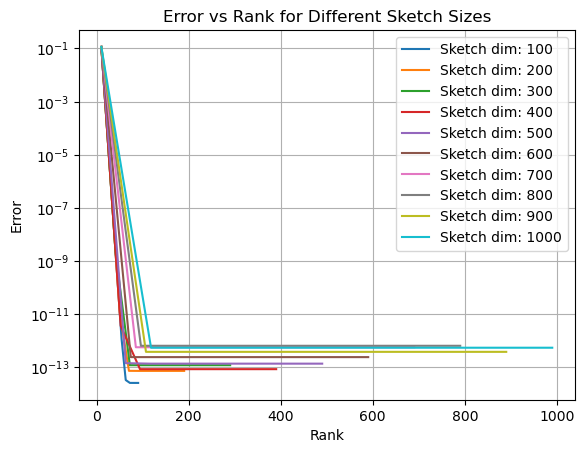

In [134]:
import matplotlib.pyplot as plt
# Tracer les erreurs
for sketch_dim, rank_errors in errors.items():
    ranks = list(rank_errors.keys())
    errs = list(rank_errors.values())
    plt.plot(ranks, errs, label=f'Sketch dim: {sketch_dim}')

plt.xlabel('Rank')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Error vs Rank for Different Sketch Sizes')
plt.legend()
plt.grid(True)
plt.show()
